In [1]:
%load_ext autoreload
# reload modules automatically before each cell
%autoreload 2

import requests
import os
os.environ["REQUESTS_CA_BUNDLE"] = "/etc/ssl/certs/ca-certificates.crt" # if not already set by the OS; doesn't hurt

# fixes a bug in SPARQLwrapper
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# importing pandas to make printed dataframes prettier
import pandas as pd, hashlib
pd.set_option('display.max_colwidth', None)
pd.set_option('display.colheader_justify', 'left')
pd.set_option('display.width', 200)

In [2]:
from pmd_demo_tools import mesh_tools, sparql_tools
from pmd_demo_tools.query_collection import S355queries
S355queries = S355queries()

In [3]:
# read in all servers on the mesh
partners_full = mesh_tools.mesh_namespace_grouped_by_company()

# attach hosted services
_ = mesh_tools.attach_services_in_place(partners_full)

# attach web tokens
import json
with open('../secrets/tokens.json') as f:
    tokens = json.load(f, object_hook=mesh_tools.namespace_object_hook())

partners_full.Leibniz_Institut_fuer_Werkstofforientierte_Technologien_IWT.iwt.services.ontodocker.token = tokens.Leibniz_Institut_fuer_Werkstofforientierte_Technologien_IWT.ontodocker.token
partners_full.Fraunhofer_IWM.iwm.services.ontodocker.token = tokens.Fraunhofer_IWM.ontodocker.token
partners_full.KIT.kit_3.services.ontodocker_proxy.token = tokens.KIT.ontodocker_proxy.token
partners_full.MPISusMat.mpi_susmat.services.ontodocker.token = tokens.MPISusMat.ontodocker.token

/home/jovyan/work/pmd_mesh-demonstrator/pmd_demo_tools/pmd_demo_tools/mesh_tools.py:606: UserWarning: Failed fetching services for glassomer.pmd.internal: 500 Server Error: Internal Server Error for url: http://mesh-listing.c.pmd.internal/api/v1/pmds/glassomer.pmd.internal.
  warnings.warn(f"Failed fetching services for {zone}: {e}.", category=UserWarning)


In [42]:
selection = ["Leibniz_Institut_fuer_Werkstofforientierte_Technologien_IWT", "Fraunhofer_IWM", "KIT"]
partners = mesh_tools.select_toplevel(partners_full, selection, deepcopy=True)

In [43]:
datasets = ["pmdco2_tto_example_parallel", "pmdco2_tto_example_perpendicular","pmdco2_tto_example_diagonal"]

In [122]:
query = S355queries.orientation()
orientation_results = sparql_tools.federated_query(partners=partners, datasets=datasets, query=query.query, columns=query.headers, print_to_screen=False)
orientation_results_rns = mesh_tools.RecursiveNamespace(**orientation_results)
type(query)

pmd_demo_tools.sparql_tools.SparqlQuery

In [45]:
orientation_uri_term = S355queries.orientation().headers[0] # uri
orientation_term = S355queries.orientation().headers[1] # cut orientation

In [46]:
query = S355queries.csv_url()
csv_url_results = sparql_tools.federated_query(partners=partners, datasets=datasets, query=query.query, columns=query.headers, print_to_screen=False)
csv_url_results_rns = mesh_tools.RecursiveNamespace(**csv_url_results)

In [47]:
query = S355queries.csv_columns()
csv_columns_results = sparql_tools.federated_query(partners=partners, datasets=datasets, query=query.query, columns=query.headers, print_to_screen=False)
csv_columns_results_rns = mesh_tools.RecursiveNamespace(**csv_columns_results)

In [48]:
csv_uri_term = S355queries.csv_columns().headers[0] # uri
csv_url_term = S355queries.csv_columns().headers[1] # url
csv_id_term = S355queries.csv_columns().headers[2] # name
csv_column_number_term = S355queries.csv_columns().headers[3] # column number
csv_quantity_term = S355queries.csv_columns().headers[4] # quantity
csv_unit_term = S355queries.csv_columns().headers[5] # unit

In [49]:
query = S355queries.primary_data()
primary_data_results = sparql_tools.federated_query(partners=partners, datasets=datasets, query=query.query, columns=query.headers, print_to_screen=False)
primary_data_results_rns = mesh_tools.RecursiveNamespace(**primary_data_results)

In [50]:
primary_uri_term = S355queries.primary_data().headers[0] # uri
primary_quantity_term = S355queries.primary_data().headers[1] # quantity
primary_value_term = S355queries.primary_data().headers[2] # value
primary_unit_term = S355queries.primary_data().headers[3] # unit
cross_section_term = "crossSectionArea_S0"

In [51]:
pmd_prefix = "https://w3id.org/pmd/co/"
displacement_term = "CrossheadSeparation"
displacement_expression = pmd_prefix+displacement_term
force_term = "Force"
force_expression = pmd_prefix+force_term

strain_term = "PercentageExtension"
strain_expression = pmd_prefix+strain_term 

unit_prefix = "http://qudt.org/vocab/unit/"
displacement_unit_expected = "http://qudt.org/vocab/unit/MilliM"
strain_unit_expected = "http://qudt.org/vocab/unit/PERCENT"
force_unit_expected = "http://qudt.org/vocab/unit/KiloN"
cross_section_unit_expected = "http://qudt.org/vocab/unit/MilliM2"

In [52]:
import numpy as np

def calc_stress(force: np.array, cross_section_area: float) -> np.array:
    return force/cross_section_area

In [53]:
from scipy.optimize import curve_fit

from dataclasses import dataclass

@dataclass
class ElasticModulusCalculation:
    elastic_modulus: float
    variance_elastic_modulus: float
    stress_offset: float
    variance_stress_offset: float
    elastic_strain_limit: float
    elastic_limit_index: int

def calc_elastic_modulus(stress: np.array, strain: np.array, elastic_strain_limit: float = 0.001) -> ElasticModulusCalculation:
    def lin_func(x,a,b):
        return a*x+b
 
    elastic_limit_index = 0
    while strain[elastic_limit_index] <= elastic_strain_limit:
        elastic_limit_index += 1

    popt, pcov = curve_fit(lin_func, strain[:elastic_limit_index+1], stress[:elastic_limit_index+1], p0=np.asarray([400000.,-1000000.]))

    elastic_modulus = popt[0]
    stress_offset = popt[1]
    variance_elastic_modulus = pcov[0,0]
    variance_stress_offset = pcov[1,1]
    elastic_strain_limit = strain[elastic_limit_index]
    return ElasticModulusCalculation(elastic_modulus, variance_elastic_modulus, stress_offset, variance_stress_offset, elastic_strain_limit, elastic_limit_index)

In [54]:
@dataclass
class OffsetYieldCalculation:
    offset_strain: float
    yield_stress: float
    yield_strain: float


def offset_yield_calculation(stress: np.array, strain: np.array, elastic_modulus: float | None = None, offset_strain: float = 0.2) -> float:
    if elastic_modulus is None:
        E = calc_elastic_modulus(stress=stress, strain=strain)
        elastic_modulus = E.elastic_modulus
    elastic_line = elastic_modulus*((strain[:900])-offset_strain)
    diff = strain[:900]-elastic_line
    arg = np.argmin(diff)
    yield_stress = stress[arg]
    yield_strain = strain[arg]
    return OffsetYieldCalculation(offset_strain, yield_stress, yield_strain)

In [62]:
url_results_list = [csv_url_results_rns.Leibniz_Institut_fuer_Werkstofforientierte_Technologien_IWT_iwt.ontodocker.pmdco2_tto_example_parallel.result,
                    csv_url_results_rns.KIT_kit_3.ontodocker_proxy.pmdco2_tto_example_perpendicular.result,
                    csv_url_results_rns.Fraunhofer_IWM_iwm.ontodocker.pmdco2_tto_example_diagonal.result
                   ]

columns_results_list = [csv_columns_results_rns.Leibniz_Institut_fuer_Werkstofforientierte_Technologien_IWT_iwt.ontodocker.pmdco2_tto_example_parallel.result,
                        csv_columns_results_rns.KIT_kit_3.ontodocker_proxy.pmdco2_tto_example_perpendicular.result,
                        csv_columns_results_rns.Fraunhofer_IWM_iwm.ontodocker.pmdco2_tto_example_diagonal.result
                       ]
rolling_direction_results_list =[orientation_results_rns.Leibniz_Institut_fuer_Werkstofforientierte_Technologien_IWT_iwt.ontodocker.pmdco2_tto_example_parallel.result,
                                 orientation_results_rns.KIT_kit_3.ontodocker_proxy.pmdco2_tto_example_perpendicular.result,
                                 orientation_results_rns.Fraunhofer_IWM_iwm.ontodocker.pmdco2_tto_example_diagonal.result
                                ]

primary_data_results_list = [primary_data_results_rns.Leibniz_Institut_fuer_Werkstofforientierte_Technologien_IWT_iwt.ontodocker.pmdco2_tto_example_parallel.result,
                             primary_data_results_rns.KIT_kit_3.ontodocker_proxy.pmdco2_tto_example_perpendicular.result,
                             primary_data_results_rns.Fraunhofer_IWM_iwm.ontodocker.pmdco2_tto_example_diagonal.result
                            ]

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

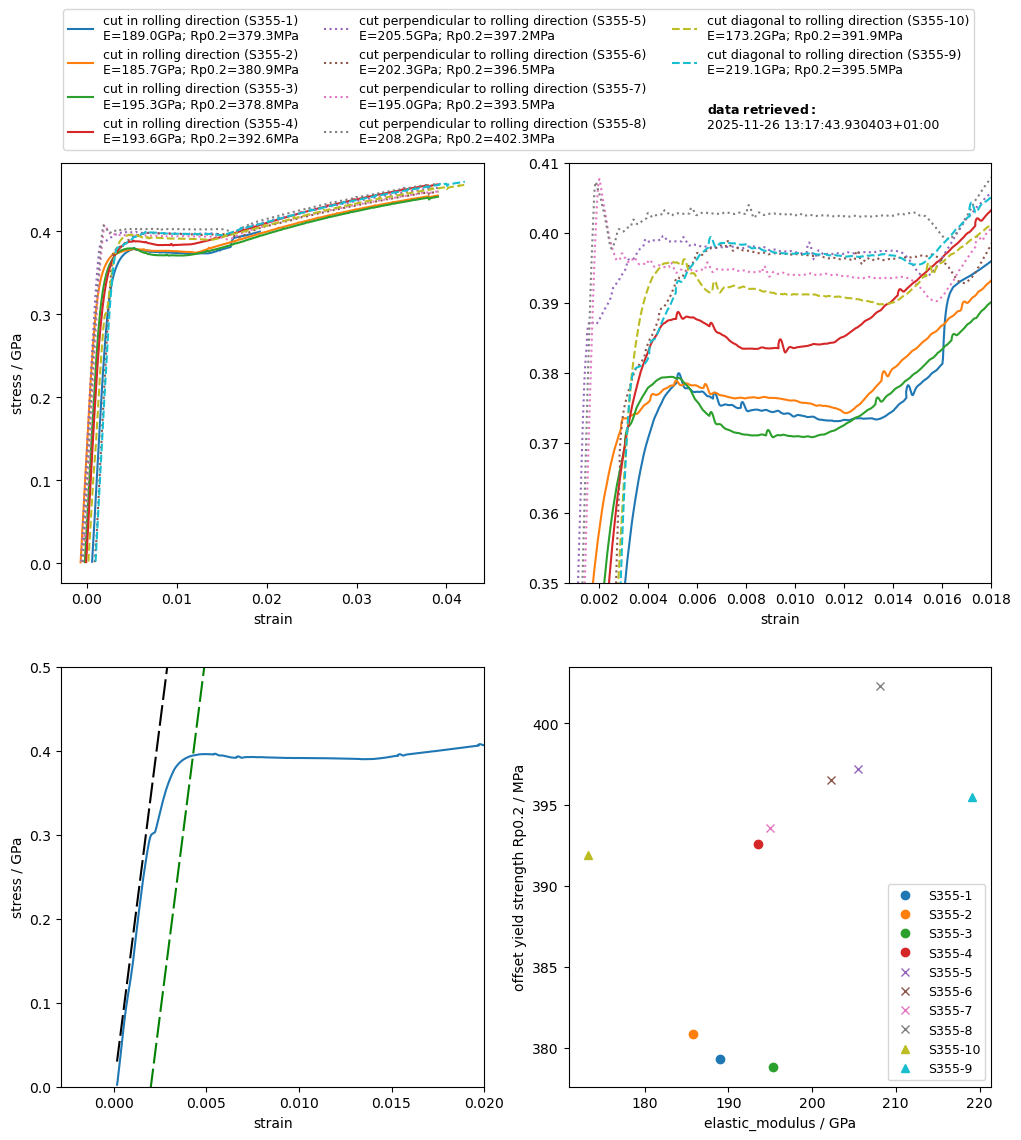

In [120]:
fig_fd, ax_fd = plt.subplots(2,2, figsize=(12,12))
linestyles = ("solid", "dotted", "dashed")
markers = ("o", "x", "^")
for url_results, columns_results, roll_dir_results, primary_data_results, linestyle, marker in zip(url_results_list, columns_results_list, rolling_direction_results_list, primary_data_results_list, linestyles, markers):
    for url, uri in zip(url_results[S355queries.csv_url().headers[1]], url_results[S355queries.csv_url().headers[0]]):

        # check strain unit consistency
        strain_unit = columns_results.query(f"{csv_uri_term} == @uri and {csv_quantity_term} == @strain_expression")[csv_unit_term].values[0]
        if not strain_unit == strain_unit_expected:
            warnings.warn("Inconsistent strain units detected!", category=UserWarning)
            # conversion ...

        # assign strain column number
        strain_column_number = int(columns_results.query(f"{csv_uri_term} == @uri and {csv_quantity_term} == @strain_expression")[csv_column_number_term].values[0])-1

        # check force unit consistency
        force_unit = columns_results.query(f"{csv_uri_term} == @uri and {csv_quantity_term} == @force_expression")[csv_unit_term].values[0]
        if not force_unit == force_unit_expected:
            warnings.warn("Inconsistent force units detected!", category=UserWarning)
            # conversion ...

        # assign force column number
        force_column_number = int(columns_results.query(f"{csv_uri_term} == @uri and {csv_quantity_term} == @force_expression")[csv_column_number_term].values[0])-1

        # check cross section unit
        cross_section_unit = primary_data_results.query(f"{primary_uri_term} == @uri and `{primary_quantity_term}`.str.contains(@cross_section_term, na=False)", engine="python")[primary_unit_term].values[0]
        if not cross_section_unit == cross_section_unit_expected:
            warnings.warn("Inconsistent cross section units detected!", category=UserWarning)
            # conversion ...

        # assign cross section
        cross_section = float(primary_data_results.query(f"{primary_uri_term} == @uri and `{primary_quantity_term}`.str.contains(@cross_section_term, na=False)", engine="python")[primary_value_term].values[0])
        
        #roll_dir = roll_dir_results.loc[roll_dir_mask, S355queries.orientation().headers[1]].iloc[0]
        roll_dir = roll_dir_results.query(f"{orientation_uri_term} == @uri")[orientation_term].values[0]
        
        # read csv from ressource location
        csv = pd.read_csv(url, delimiter=";", decimal=",", on_bad_lines='skip', skiprows=[1])

        strain = csv.iloc[:, strain_column_number]/100.
        
        force = csv.iloc[:, force_column_number]
        stress = force/cross_section
        
        E = calc_elastic_modulus(stress=stress, strain=strain) # is already stadard unit: kN/mm^2 = GPa
        e_mod = E.elastic_modulus
        Rp = offset_yield_calculation(stress=stress, strain=strain, elastic_modulus=E.elastic_modulus, offset_strain=0.2)
        yield_stress_02 = Rp.yield_stress*1e+03 # convert kN/mm^2 to MPa

        identifier = uri.replace("https://w3id.org/pmd/ao/tte/pmdao-tto-tt-","")
        identifier = identifier.replace("_process", "")
        ax_fd[0][0].plot(strain, stress, linestyle=linestyle, label=f"cut {roll_dir} ({identifier})\nE={e_mod:.1f}GPa; Rp0.2={yield_stress_02:.1f}MPa")
        ax_fd[0][1].plot(strain, stress, linestyle=linestyle, label=f"cut {roll_dir}")

        if uri == "https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-10_process":
            ax_fd[1][0].plot(strain, stress, linestyle='solid')
            ax_fd[1][0].plot(strain, E.elastic_modulus*strain, color="k", dashes=(10.,2.5))
            ax_fd[1][0].plot(strain, E.elastic_modulus*(strain-0.002), color="g", dashes=(10.,2.5))

        ax_fd[1][1].plot([e_mod], [yield_stress_02], marker=marker, linestyle="None", label=f"{identifier}")

ax_fd[0][0].set_xlabel("strain")
ax_fd[0][0].set_ylabel("stress"+" / GPa")

ax_fd[0][1].set_xlabel(ax_fd[0][0].get_xlabel())

ax_fd[1][0].set_xlabel(ax_fd[0][0].get_xlabel())
ax_fd[1][0].set_ylabel(ax_fd[0][0].get_ylabel())

ax_fd[1][1].set_xlabel("elastic_modulus / GPa")
ax_fd[1][1].set_ylabel("offset yield strength Rp0.2 / MPa")

#dummy plot to adjust legend
ax_fd[0][0].plot(0,0,ls="None", c="None", label=" ")
#ax_fd[0][0].plot(0,0,ls="None", c="None", label=" ")

# put timestamp of data retrieval into figure legend
timestamp = pd.Timestamp.now(tz="Europe/Berlin")
ax_fd[0][0].plot(0,0,ls="None", c="None", label=r"$\bf{{data\ retrieved:}}$"+ f"\n{timestamp}")

ax_fd[0][1].set_xlim(left=.00075, right=.018)
ax_fd[0][1].set_ylim(bottom=.35, top=.41)

#print(ax_fd[0][1].get_xlim())
ax_fd[1][0].set_xlim(left=ax_fd[0][0].get_xlim()[0], right=0.02)
ax_fd[1][0].set_ylim(bottom=0., top=0.5)

ax_fd[0][0].legend(loc="upper left", bbox_to_anchor=(-0.01, 1.38), ncol=3, fontsize=9.)
ax_fd[1][1].legend(loc="lower right", ncol=1, fontsize=9.)

fig_fd.show()

In [113]:
fig_fd.savefig(fname="S355_stress-strain-overview.png", bbox_inches="tight")